# Perform inference with trained yolo model

## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}"

In [2]:
from pathlib import Path
import cv2
import hydra
from hydra import compose, initialize
import supervision as sv

In [3]:
import torch

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


## Paths setup

In [4]:
from omegaconf import DictConfig

with initialize(config_path="../configs", job_name="EDA", version_base=None):
    cfg: DictConfig = compose(config_name="inference.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'results_dir': '${paths.root_dir}/results', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}', 'pretrained_model_dir': '${paths.root_dir}/pretrained_models', 'train_bst_model': '${paths.root_dir}/results/final_yolov11l_weights/best.pt', 'train_lst_model': '${paths.root_dir}/results/final_yolov11l_weights/last.pt'}


In [5]:
cfg.args

{'project': '${paths.results_dir}', 'name': 'inference-${task_name}', 'imgsz': 1280, 'half': True, 'device': 0, 'plots': True, 'verbose': True, 'workers': 16}

In [6]:
# auto reload libs
%load_ext autoreload
%autoreload 2

## Download Datasets

In [7]:
ROOT_DIR = Path(cfg.paths.root_dir)
ROOT_DATA_DIR = Path(cfg.paths.root_data_dir)
DATA_DIR = ROOT_DATA_DIR / cfg.datasets.datasets_dir
DATASET  = cfg.datasets.roboflow
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR = DATA_DIR/ cfg.datasets.dataset_name
CLASS_NAMES = cfg.datasets.names

In [8]:
if len(list(DATA_DIR.iterdir())) == 0:
    from roboflow import Roboflow

    rf = Roboflow()
    project = rf.workspace(DATASET.workspace).project(DATASET.project)
    version = project.version(DATASET.version)
    dataset = version.download(model_format=DATASET.model)

## Paths Setup

In [9]:
cfg.paths.train_bst_model, cfg.paths.train_lst_model

('/workspaces/football-players-tracking-yolo/results/final_yolov11l_weights/best.pt',
 '/workspaces/football-players-tracking-yolo/results/final_yolov11l_weights/last.pt')

In [10]:
TRAIN_BST_MODEL = cfg.paths.train_bst_model
TRAIN_LST_MODEL = cfg.paths.train_lst_model

## YOLO model import

In [11]:
from ultralytics import YOLO
model = YOLO(TRAIN_BST_MODEL)

In [12]:
# model.val(data=cfg.datasets.dataset_yaml, 
#           **cfg.args)

## Inference on Video

In [13]:
import supervision as sv
TEST_VIDEO = '/workspaces/football-players-tracking-yolo/data/0bfacc_0.mp4'

In [14]:
%matplotlib inline

In [27]:
from matplotlib import pyplot as plt


frame_generator = sv.get_video_frames_generator(TEST_VIDEO)

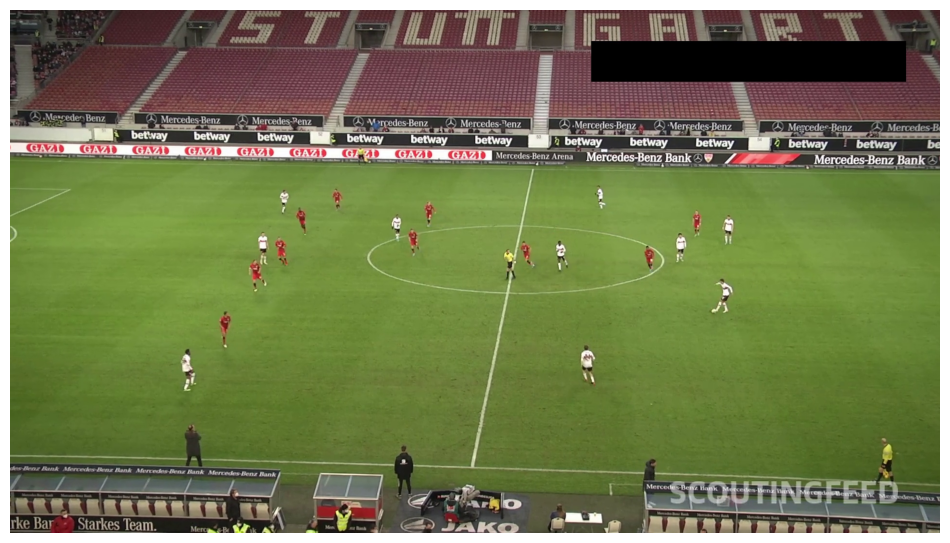

In [69]:
frame = next(frame_generator)
sv.plot_image(frame)

In [70]:
BALL_ID = 0
colors = [sv.Color.WHITE, sv.Color.RED, sv.Color.RED, sv.Color.BLUE]

ellip_annotator = sv.EllipseAnnotator(color=colors,thickness=2)
traingle_annot = sv.TriangleAnnotator(color=sv.Color.WHITE)

In [71]:
frame_generator = sv.get_video_frames_generator(TEST_VIDEO)
frame = next(frame_generator)

result = model.predict(frame, imgsz=cfg.args.imgsz, conf=0.5)[0]
result


0: 736x1280 20 players, 3 referees, 20.5ms
Speed: 12.4ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}
obb: None
orig_img: array([[[ 24,  23,  33],
        [ 24,  23,  33],
        [ 23,  22,  32],
        ...,
        [ 73,  88,  91],
        [ 73,  88,  91],
        [ 73,  88,  91]],

       [[ 31,  30,  40],
        [ 30,  29,  39],
        [ 30,  29,  39],
        ...,
        [ 73,  88,  91],
        [ 73,  88,  91],
        [ 73,  88,  91]],

       [[ 29,  28,  38],
        [ 29,  28,  38],
        [ 28,  27,  37],
        ...,
        [ 73,  88,  91],
        [ 73,  88,  91],
        [ 73,  88,  91]],

       ...,

       [[ 67,  78,  86],
        [ 63,  74,  82],
        [ 60,  71,  79],
        ...,
        [ 16,  18,  20],
        [ 20,  22,  24],
        [ 22,  24,  26]],

       [[ 98, 109, 117],
        [ 98, 109, 117],
        [ 95, 106, 114],
        ...,
        [ 28,  30,  3

In [74]:
detections = sv.Detections.from_ultralytics(result)
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

rest_detections = detections[detections.class_id != BALL_ID]
rest_detections= rest_detections.with_nms(threshold=0.5, class_agnostic=True)
rest_detections.class_id -=1

In [76]:
annot_frame = frame.copy()
annot_frame = ellip_annotator.annotate(scene=annot_frame, detections=rest_detections)
annot_frame

AttributeError: 'list' object has no attribute 'as_bgr'

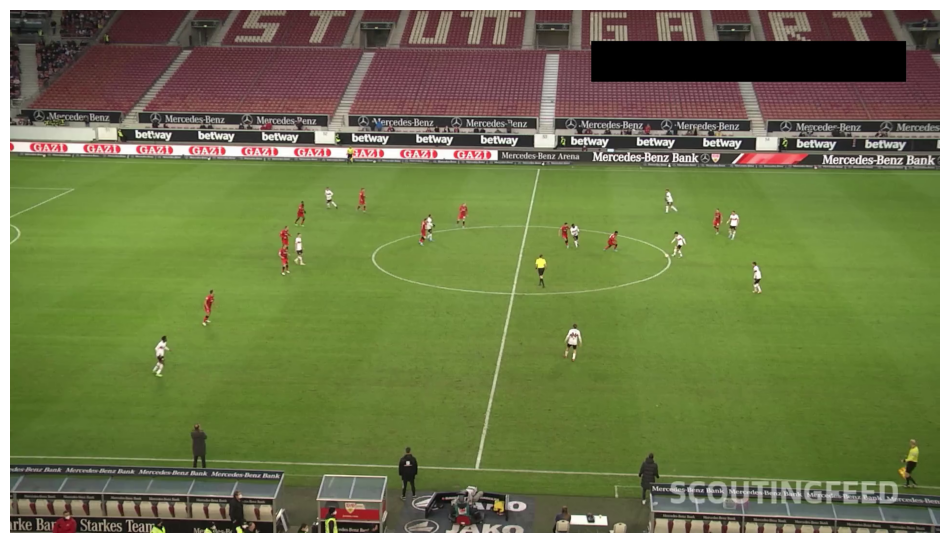

In [ ]:

annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)

sv.plot_image(annot_frame)